In [1]:
#This script filters the single domain antibody and full lenght antibody dataset seperately based on the CDR sequence
#The input is the dataframe containing the epitopes and paratopes of each interaction in the dataset
#@Author: Henriette Capel
#@Date: 10 March 2022
#@Reviewed: 22 March 2022 (Annabel Ling)
#@Editted: 23 March 2022 (Henriette Capel)

In [2]:
#Import modules
from ABDB import database as db
import pandas as pd
import ast
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import matplotlib.pyplot as plt
from Bio import SeqIO

%load_ext nb_black

/data/icarus/capel/miniconda3/envs/minor_internship/lib/python3.10/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [4]:
#Constant
INTERACTION_SIZE_CUTOFF = 6
EPITOPE_SIMILARITY_CUTOFF = 0.75

In [15]:
def read_dataset(filename_ds):
    #Function reads in dataset and makes sure the elements in the dictionary stay in a dictionary
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

def extra_filtering_steps(file_name, size_cutoff, list_pdbs_to_remove, writing_file = False):
    #open dataframe dataset
    df = read_dataset(file_name)
    
    #Remove determined outliers
    df_filter_outliers = filter_out_outliers(df, list_pdbs_to_remove)
    df_filter_outliers = df_filter_outliers.reset_index(drop=True)
    
    #First filter on the complexes as indicated by SAbDab:
    df_filter_SAbDab_complex = filter_on_complexes_indicated_by_SAbDab(df_filter_outliers)
    df_filter_SAbDab_complex = df_filter_SAbDab_complex.reset_index(drop=True)

    #Filter on epitope and paratope size  
    df_filtered_epi_para_size =filter_on_epitope_paratope_size(df_filter_SAbDab_complex, file_name, size_cutoff)
    df_filtered_epi_para_size = df_filtered_epi_para_size.reset_index(drop=True)
    
    ##Write to file
    if writing_file:
        print("NOTE: you are writing to a file")
        ab_type = file_name.split("_")[0]
        output_file_name = f"{ab_type}_epitope_paratope_filter_co{size_cutoff}.csv"
        df_filtered_epi_para_size.to_csv(output_file_name, index=False)
   
    return df_filtered_epi_para_size
    
def filter_out_outliers(df, list_pdbs_to_remove):
    df_old_shape = df.shape
    for outlier_pdb in list_pdbs_to_remove:
        list_information_outlier = outlier_pdb.split("_")
        if len(list_information_outlier) ==1: #only pdb_id indicated; remove all columns that have this pdb
            df.drop(df.index[df["pdb"]==outlier_pdb], inplace=True)
        else: #ab chain is given
            df.drop(df.index[(df["pdb"]==list_information_outlier[0]) & (df["antibody_chain"]==list_information_outlier[1])], inplace=True)
            
        
    removed_rows = df_old_shape[0] - df.shape[0]
    print(f"{removed_rows} rows removed based on {len(list_pdbs_to_remove)} selected outliers")
    return df
        

def filter_on_complexes_indicated_by_SAbDab(df):
    #The dataset contains antibody-antigen complexes which are not interacting according to SAbDAb. 
    #This could be due to the difference between assymetric unit and biologically assembly. 
    #This function filtered the complexes which are not present according to SAbDab out of the dataset
    
    filter_out_index = []
    for index, row in df.iterrows():
        pdb_id = row["pdb"]
        ag_chain = row["antigen_chain"]
        ab_chain = row["antibody_chain"]
        
        #Look into SAbDab and filter out antibodies not connecting to right antigen
        p = db.fetch(pdb_id)
        for fab in p.get_fabs():
            fab_chain_id = str(fab).split("\n")[0].split(" ")[1]#construct chain out of fab
            if fab_chain_id == ab_chain:
                antigen_details = fab.get_antigen() # get the details of the antigen the fab is bound to
                antigen_chain_details = str(antigen_details).split(" = ")[1]
                if ag_chain not in antigen_chain_details: 
                    filter_out_index.append(index)
                    
    df_filtered_SAbDab = df.drop(df.index[filter_out_index]) 
    print(f"{len(filter_out_index)} rowes removed based on ab_chain-ag_chain interaction SAbDab; dataset size is not {df_filtered_SAbDab.shape[0]} instead of {df.shape[0]}")
    return df_filtered_SAbDab

def filter_on_epitope_paratope_size(df, filename_df, size_cutoff):
    #We decided to filter out the complexes for which the size (number of amino acids) of the paratope and/or epitope is smaller than a certain threshold
    #We set the threshold after checking dataset sizes for different cutoffs between 5-10 aa. 
    ab_type = filename_df.split("_")[0]
    
    #filter on epitope size
    if ab_type == "Fv": #Check if dealing with full length domain 
        df_epi_filtered = df[df['epitope_MWV_dict'].map(lambda x: determine_length_epitope_fv_dict(x) > size_cutoff)]
    else: 
        df_epi_filtered = df[df['epitope_MWV_dict'].map(lambda x: len(x.keys()) > size_cutoff)]
                  
    print(f"Number of rows in dataframe after epitope filtering: {len(df_epi_filtered)}")
    
    #filter on paratope size
    if ab_type == "Fv": #Check if dealing with full length domain 
        df_epi_para_filtered = df_epi_filtered[df_epi_filtered['paratope_MWV_dict'].map(lambda x: determine_length_paratope_fv_dict(x) > size_cutoff)]
    else: 
        df_epi_para_filtered = df_epi_filtered[df_epi_filtered['paratope_MWV_dict'].map(lambda x: len(x.keys()) > size_cutoff)]
    
    print(f"Number of rows in dataframe after paratope filtering: {len(df_epi_para_filtered)}")
    
    return df_epi_para_filtered

def determine_length_epitope_fv_dict(epitope_fv_dict):
    #epitope_fv_dict has elements: heavy, light and combined chain. We need the length of combined
    for chain_id in epitope_fv_dict.keys():
        if len(chain_id) == 2:
            epitope_residues_dict = epitope_fv_dict[chain_id]
            length_epi = len(epitope_residues_dict.keys())
    return length_epi

def determine_length_paratope_fv_dict(paratope_fv_dict):
    #For full length antibodies the paratope is stored as a dictionary where heavy and light chain are the keys.
    #Need to sum the elements determined by both chains. 
    length_para = 0
    for chain in paratope_fv_dict.keys():
        length_para += len(paratope_fv_dict[chain].keys())
    return length_para
    
def create_input_cdhit(filename_df, filename_fasta, cdr_type):
    #Read the dataframe (filename_df) containing epitopes and paratopes of all interactions in the dataset
    #makes a fasta format file (filename_fasta) contianing pdb, antigen chain, antibody chain and the sequence 
    #of the prefered cdr_type (use CDRH for nanobodies and CDRHL for full length antibodies)
    df = read_dataset(filename_df)
    df_target_seq = add_cdrseq_as_column_df(df, cdr_type) #add cdr sequence as new row to dataframe
    create_fasta_format_file(df_target_seq, filename_fasta, cdr_type) #create the fasta file
    
    return None

def add_cdrseq_as_column_df(df, cdr_type):
    #df = format_dataframe_correctly(df)
    cdrh_seq = df['cdr_sequence']
    list_cdrh = []
    for dict_cdr in cdrh_seq:
        list_cdrh.append(dict_cdr[cdr_type])
    df.loc[:,f'{cdr_type}_sequence'] = list_cdrh
    
    return df

def create_fasta_format_file(df, filename, cdr_type):
    #Create input for CDhit
    with open(f"{filename}.txt", "w") as file:
        for index, row in df.iterrows():
            pdb_id = row["pdb"]
            ag_chain = row["antigen_chain"]
            ab_chain = row["antibody_chain"]
            cdr_seq = row[f"{cdr_type}_sequence"]
            file.write(f">{pdb_id}_{ag_chain}_{ab_chain}\n")
            file.write(f"{cdr_seq}\n")
    return None

##Functions using result of CDhit. 
def store_representative_seq_ids(filterd_cdhit_filename): 
    #Store representative sequence ids as selected by CDhit
    list_ids = []
    for record in SeqIO.parse(filterd_cdhit_filename, "fasta"):
        list_ids.append(record.id)
    return list_ids

def store_cluster_info(cluster_filename):
    #Read cluster result document of CDhit and store clusters in dictionary
    dict_clusters = {}
    with open(f"{cluster_filename}") as file:
        for index, line in enumerate(file):
            if line[0] == ">":
                #Store previous cluster if exist
                try:
                    dict_inside_cluster[representative_id] = list_filtered_out
                    dict_clusters[clusnum] = dict_inside_cluster
                except UnboundLocalError: #Refered before exist
                    pass
                clusnum = line.strip("\n").split(" ")[1]
                dict_inside_cluster = {}
                
            else:  #line[0] != ">" so we are inside a cluster
                list_line = line.split("\t")[-1].split(", ")[-1].strip("\n").split("... ") #Break up the lines of CDhit output
                #list_line takes the form [>pdb_agchain_abchain, *] for representative, and [>pdb_agchain_abchain, at value%] for filtered
                if list_line[1] == "*":
                    list_filtered_out = []
                    representative_id = list_line[0][1:]
                else:
                    filtered_seq_id = list_line[0][1:]
                    list_filtered_out.append(filtered_seq_id)
    return dict_clusters

def select_corresponding_epitope(entry_id, df):
    df_entry_id = select_df_row(entry_id, df)
    epitope_binary = df_entry_id['epitope_binary_MWV'].values[0]
    
    return epitope_binary

def select_df_row(entry_id, df):
    #Select the row based on the entry id (pdb_agchin_abchain)
    pdb_id, ag_chain, ab_chain = entry_id.split("_")
    df_entry_id = df[(df['pdb'] == pdb_id) & (df['antigen_chain'] == ag_chain) & (df['antibody_chain'] == ab_chain)]
    
    return df_entry_id
    
def create_filtered_ds(filename_notfiltered_df, list_representatives, list_different_epitope):
    #Create a filtered dataset.
    #Takes the not filtered dataset (df_notfiltered), select the representative interactions according to cdhit filtering (list_representatives)
    #and the interactions of redundant sequences with different epitopes (list_different_epitopes)
    
    df_notfiltered = pd.read_csv(filename_notfiltered_df)
    
    #Create empty dataset with same column names as before
    column_names = list(df_notfiltered.columns.values)[1:]
    df_ds = pd.DataFrame(columns=column_names)
    
    #Store selected data in the new dataframe
    list_selected_seq = list_representatives + list_different_epitope
    for selected_id in list_selected_seq:
        df_new_line = select_df_row(selected_id, df_notfiltered)
        df_ds = pd.concat([df_ds, df_new_line])
    
    df_ds = df_ds.drop(columns=['Unnamed: 0'])
    return df_ds


### Functions to determine similarity between epitopes
def calculate_store_epitope_similarity_cluster(cluster_filename, filename_df, ab_type):
    df_input = read_dataset(filename_df)
    
    dict_cluster_eptipe_similarity = {}
    dict_clusters_ids = store_cluster_info(cluster_filename)
    
    for cluster_number in dict_clusters_ids.keys():
        dict_similarity_score = {}
        
        #Store similarity between representative and all filtered sequences in its cluster
        dict_base_similarity_score = {}
        representative_id = list(dict_clusters_ids[cluster_number].keys())[0] #All clusters have only one representative 
        representative_antigen_seq, representative_epitope_seq = get_antigen_epitope_seq(representative_id, df_input, ab_type)
        
        for filtered_id in dict_clusters_ids[cluster_number][representative_id]:
            filtered_antigen_seq, filtered_epitope_seq = get_antigen_epitope_seq(filtered_id, df_input, ab_type)
            
            #Determine similarity score and save
            similarity_score = determine_epitope_similarity(representative_antigen_seq, filtered_antigen_seq, representative_epitope_seq, filtered_epitope_seq)
            dict_similarity_score[filtered_id] = similarity_score
            
        dict_base_similarity_score[representative_id] = dict_similarity_score
        
        #Store also similarity between filtered sequences within a cluster
        filtered_seq_list = dict_clusters_ids[cluster_number][representative_id]
        
        for i in range(len(filtered_seq_list)):
            dict_similarity_score = {}
            base_id = filtered_seq_list[i]
            base_antigen_seq, base_epitope_seq = get_antigen_epitope_seq(base_id, df_input, ab_type)

            
            for j in range(i+1, len(filtered_seq_list)):
                align_id = filtered_seq_list[j]
                align_antigen_seq, align_epitope_seq = get_antigen_epitope_seq(align_id, df_input, ab_type)

                #Determine similarity score and store
                similarity_score = determine_epitope_similarity(base_antigen_seq, align_antigen_seq, base_epitope_seq, align_epitope_seq)
                dict_similarity_score[align_id] = similarity_score
            
            dict_base_similarity_score[base_id] = dict_similarity_score
        dict_cluster_eptipe_similarity[cluster_number] = dict_base_similarity_score
        
    return dict_cluster_eptipe_similarity

def get_antigen_epitope_seq(selected_id, df, ab_type):
    selected_df_row = select_df_row(selected_id, df)
    antigen_seq = selected_df_row['antigen_sequence'].values[0]
    epitope_seq = select_epitope_sequence_from_dfrow(selected_df_row, ab_type)
    
    return antigen_seq, epitope_seq

def select_epitope_sequence_from_dfrow(df_row, ab_type):
    if ab_type == "Fv":
        epitope_per_chain_dict = df_row['epitope_MWV'].values[0]
        for ab_chain in epitope_per_chain_dict.keys():
            if len(ab_chain) == 2: #The light and heavy chain combined
                epitope_seq = epitope_per_chain_dict[ab_chain]
    else:
        epitope_seq = df_row['epitope_MWV'].values[0]
        
    return epitope_seq

def determine_epitope_similarity(seq_A, seq_B, epi_A, epi_B):
    #The similarity score is defined as the number of epitope residues of similar amino acid type and position in alignment over the number of all indicated epitope positions in the two sequences.
    #A global alignment is first used to create a sequence alignment for the two antigens. 
    #Next the similarity score of the epitope residues in the alignment is calculated. 
    #epi_A and epi_B are sequences of the length of the antigen sequence with "-" in residue positions which do not belong to the epitope and the amino acid at the position if it is an epitope residue
    
    test_alignment = pairwise2.align.globalxx(seq_A, seq_B)
    similarity_scores = []
    for alignment in test_alignment:
        align_A, align_B, score, start, end = alignment
        
        align_epitope_seq_A = get_aligned_epitope_positions(align_A, epi_A)
        align_epitope_seq_B = get_aligned_epitope_positions(align_B, epi_B)
 
        ratio_similar = compare_epitopes_aligned(align_epitope_seq_A, align_epitope_seq_B)
        
        similarity_scores.append(ratio_similar)
    
    max_similarity_score = max(similarity_scores)
    
    return max_similarity_score

def get_aligned_epitope_positions(aligned_seq, epitope_seq):
    aligned_positions = get_align_positions(aligned_seq)
    align_epitope_dict = determine_epitope_positions_alignment(epitope_seq, aligned_positions)
    align_epitope_seq = determine_epitope_seq_alignment(aligned_seq, align_epitope_dict)
    
    return align_epitope_seq
        

def get_align_positions(aligned_seq):
    result = []
    count = 0
    for i in range(len(aligned_seq)):
        if aligned_seq[i] == "-":
            count += 1
        else:
            result.append(count)
            count += 1
    return result

def determine_epitope_positions_alignment(epitope_seq, aligned_positions):
    #Determine the positions of the epitope residues in the alignment
    epitope_positions_aligned_dict = {}
    for i in range(len(epitope_seq)):
        if epitope_seq[i] != "-":
            epitope_positions_aligned_dict[aligned_positions[i]] = epitope_seq[i]
    return epitope_positions_aligned_dict

def determine_epitope_seq_alignment(align_seq, epitope_position_aligned_dict):
    #Store the epitope positions in the alignment as a sequence of the length of the antigen sequence. 
    #If the position is an epitope position the corresponding amino acid is presented, otherwise a dash ("-")
    epitope_seq_aligned_list = ["-"] * len(align_seq)
    for res_position in epitope_position_aligned_dict.keys():
        epitope_seq_aligned_list[res_position] = epitope_position_aligned_dict[res_position]
        
    epitope_seq_aligned = "".join(epitope_seq_aligned_list)
    return epitope_seq_aligned 
        
def compare_epitopes_aligned(align_epitope_seq_A, align_epitope_seq_B):
    #Determine the epitope identity based on position and amino acid type. 
    similarity_score = 0
    epitope_positions = 0
    for align_epitope_seq_A, align_epitope_seq_B in zip(align_epitope_seq_A,align_epitope_seq_B):
        if align_epitope_seq_A != "-":
            epitope_positions += 1
            #check if same aa as in align_epitope_seq_B
            if align_epitope_seq_A == align_epitope_seq_B:
                similarity_score += 1
            #No score if A - or A B (where A and B certain amino acids)
        else: #"-" in seq A
            if align_epitope_seq_B != "-":
                epitope_positions += 1
                
    ratio_similar = similarity_score / epitope_positions
    
    return ratio_similar

def store_filtered_ids_different_epitope(dict_cluster_epitope_similarity, cutoff_epitope_similarity):
    #Check for each cluster the epitope similarity between representative sequence (choosen by CDhit) and the filtered sequences (sequences that are filtered out by CDhit)
    #Store if epitope similarity is different.
    #Note: need to check per cluster the similarity between the filtered once if we decide to reintroduce them in the dataset. 
    list_keep_filtered_ids = []
    
    for cluster_number in dict_cluster_epitope_similarity.keys():
        representative_id = list(dict_cluster_epitope_similarity[cluster_number].keys())[0]
        store_temp = []
        for filtered_id in dict_cluster_epitope_similarity[cluster_number][representative_id]:
            score = dict_cluster_epitope_similarity[cluster_number][representative_id][filtered_id]
            if score <= cutoff_epitope_similarity:
                store_temp.append(filtered_id)

        #Check if the filtered sequences do also differ from each other
        for i in range(len(store_temp)):
            try: #Needed because list is shrinking
                base_id = store_temp[i]
                base_dict = dict_cluster_epitope_similarity[cluster_number][base_id]
                for align_id in base_dict.keys():
                    score = dict_cluster_epitope_similarity[cluster_number][base_id][align_id]
                    if score > cutoff_epitope_similarity: #meaning the base and align epitope are very similar, so we only want to include base and need to through away align
                        store_temp.remove(align_id)
            except IndexError:
                pass
            except ValueError:
                pass
        list_keep_filtered_ids.extend(store_temp)
        
    return list_keep_filtered_ids


def create_data_plot(dict_cluster_eptipe_similarity, all_combos_cluster):
    list_similarity_scores = []

    if all_combos_cluster == True:
        for cluster_number in dict_cluster_eptipe_similarity.keys():
            for base_id in dict_cluster_eptipe_similarity[cluster_number].keys():
                for align_id in dict_cluster_eptipe_similarity[cluster_number][base_id].keys():
                    similarity_score = dict_cluster_eptipe_similarity[cluster_number][base_id][align_id]
                    list_similarity_scores.append(similarity_score)
    else:
        for cluster_number in dict_cluster_eptipe_similarity.keys():
            representative_id = list(dict_cluster_eptipe_similarity[cluster_number].keys())[0]
            for align_id in dict_cluster_eptipe_similarity[cluster_number][representative_id].keys():
                similarity_score = dict_cluster_eptipe_similarity[cluster_number][representative_id][align_id]
                list_similarity_scores.append(similarity_score)
                
    return list_similarity_scores

def make_figure_epitope_identity(list_similarity_scores, dataset_type, epitope_identity_threshold, color):
    plt.hist(list_similarity_scores, 20, color = color)
    plt.axvline(epitope_identity_threshold, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel("Epitope identity")
    plt.ylabel("Frequency")
    plt.title(f"{dataset_type} antibody dataset")
    plt.show()
    # plt.savefig(f'{dataset_type}_epitope_identity.png', bbox_inches='tight')
    

def plot_epitope_identity(dict_cluster_eptipe_similarity, dataset_type, epitope_identity_threshold, color, all_combos_cluster = True):
    list_similarity_scores = create_data_plot(dict_cluster_eptipe_similarity, all_combos_cluster)  
    make_figure_epitope_identity(list_similarity_scores, dataset_type, epitope_identity_threshold, color)
    
    return None
    

In [5]:
#Remove outliers
list_chould_be_removed_nb = ["4hjj", "7d30", "6ul6","5omm"]
list_should_be_removed_fl = ["2h32", "4nzr", "4nzt", "1xiw", "5mhr_KJ", "5mhr_ML"] #Note 1xiw was present twice. 

In [6]:
#Note need to rename current files in order to create new ones

In [7]:
#Filter on SabDab complexes and on epitopa and paratope size
df_filtered_co6_nb = extra_filtering_steps("Nb_epitope_paratope.csv", INTERACTION_SIZE_CUTOFF, list_chould_be_removed_nb, writing_file = False)
df_filtered_co6_fv = extra_filtering_steps("Fv_epitope_paratope.csv", INTERACTION_SIZE_CUTOFF, list_should_be_removed_fl, writing_file = False)

6 rows removed based on 4 selected outliers
222 rowes removed based on ab_chain-ag_chain interaction SAbDab; dataset size is not 816 instead of 1038
Number of rows in dataframe after epitope filtering: 781
Number of rows in dataframe after paratope filtering: 781
7 rows removed based on 6 selected outliers
41 rowes removed based on ab_chain-ag_chain interaction SAbDab; dataset size is not 1703 instead of 1744
Number of rows in dataframe after epitope filtering: 1699
Number of rows in dataframe after paratope filtering: 1699


In [ ]:
#Single domain antibodies
#Creat fasta files
#create_input_cdhit("Nb_epitope_paratope_filter_co6.csv", "Nb_fasta_filter_co6", "CDRH")

In [ ]:
#full lenght antibodies
#create fasta files
#create_input_cdhit("Fv_epitope_paratope_filter_co6.csv", "Fv_fasta_filter_co6", "CDRHL")

In [ ]:
#RUN CD HIT ON THE SERVER (NOTE: activate conda environment first)
#cd-hit -i Nb_fasta_filter_co6.txt -o db_Nb_95_filter_co6 -c 0.95 -n 5
#cd-hit -i Fv_fasta_filter_co6.txt -o db_Fv_95_filter_co6 -c 0.95 -n 5

In [5]:
#Single domain antibodies
cdhit_result_filename = "db_Nb_95_filter_co6"
cdhit_result_cluster_filename = f"{cdhit_result_filename}.clstr"
notfiltered_df_filename = "Nb_epitope_paratope_filter_co6.csv"
ab_type = "Nb"

list_representative_nbs = store_representative_seq_ids(cdhit_result_filename)
dict_cluster_eptipe_similarity_nb = calculate_store_epitope_similarity_cluster(cdhit_result_cluster_filename, notfiltered_df_filename, ab_type)
list_keep_filtered_nbs = store_filtered_ids_different_epitope(dict_cluster_eptipe_similarity_nb, EPITOPE_SIMILARITY_CUTOFF)
df_ds_nb = create_filtered_ds(notfiltered_df_filename, list_representative_nbs, list_keep_filtered_nbs)

In [6]:
print(len(list_representative_nbs))
print(len(list_keep_filtered_nbs))
print(f"Total number of interactions in dataset {len(list_representative_nbs)+len(list_keep_filtered_nbs)}")

309
36
Total number of interactions in dataset 345


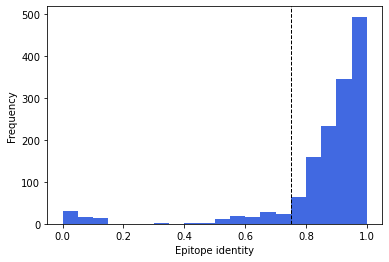

In [13]:
#Plot epitope identity score including all scores within a cluster
plot_epitope_identity(dict_cluster_eptipe_similarity_nb, "sdAb", EPITOPE_SIMILARITY_CUTOFF, "royalblue", all_combos_cluster = True)

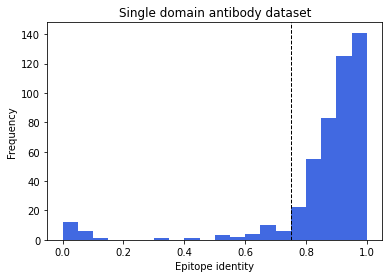

In [8]:
#Plot epitope identity score including only scores between representative-filtered sequences
plot_epitope_identity(dict_cluster_eptipe_similarity_nb, "Single domain", EPITOPE_SIMILARITY_CUTOFF,"royalblue", all_combos_cluster = False)

In [9]:
# #full length antibodies
cdhit_result_filename = "db_Fv_95_filter_co6"
cdhit_result_cluster_filename = f"{cdhit_result_filename}.clstr"
notfiltered_df_filename = "Fv_epitope_paratope_filter_co6.csv"
ab_type = "Fv"

list_representative_fvs = store_representative_seq_ids(cdhit_result_filename)
dict_cluster_eptipe_similarity_fv = calculate_store_epitope_similarity_cluster(cdhit_result_cluster_filename, notfiltered_df_filename, ab_type)
list_keep_filtered_fvs = store_filtered_ids_different_epitope(dict_cluster_eptipe_similarity_fv, EPITOPE_SIMILARITY_CUTOFF)
df_ds_fv = create_filtered_ds(notfiltered_df_filename, list_representative_fvs, list_keep_filtered_fvs)

In [10]:
print(len(list_representative_fvs))
print(len(list_keep_filtered_fvs))
print(f"Total number of interactions in dataset {len(list_representative_fvs)+len(list_keep_filtered_fvs)}")

792
100
Total number of interactions in dataset 892


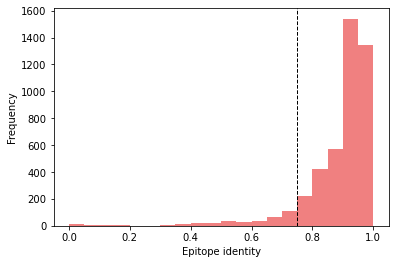

In [14]:
#Plot epitope identity(dicty score including all scores within a cluster
plot_epitope_identity(dict_cluster_eptipe_similarity_fv, "flAb", EPITOPE_SIMILARITY_CUTOFF, "lightcoral", all_combos_cluster = True)

In [ ]:
#Plot epitope identity score including only scores between representative-filtered sequences
plot_epitope_identity(dict_cluster_eptipe_similarity_fv, "Full length", EPITOPE_SIMILARITY_CUTOFF,"lightcoral", all_combos_cluster = False)

In [ ]:
## # #SAVE filtered dataset to new file
## df_ds_nb.to_csv("Dataset_nb_filtered.csv", index=False)
# df_ds_fv.to_csv("Dataset_fv_filtered.csv", index=False) 